# Setup

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: rapids-21.12


In [2]:
from pathlib import Path
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt
import numpy as np
import sklearn.manifold
import sklearn.cluster
import seaborn as sns
import pandas as pd
import sparse
import cv2

import torch
from kymatio.torch import Scattering2D

import gc
from tqdm.notebook import tqdm
import copy
import time
import random

In [3]:
# dir_github = Path(r'D:\RH_local\github').resolve()
dir_github = Path(r'/media/rich/Home_Linux_partition/github_repos/').resolve()

import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import *

%load_ext autoreload
%autoreload 2
from Big_Ugly_ROI_Tracker.multiEps.multiEps_modules import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import paths

In [4]:
# dir_allOuterFolders = Path(r"D:\RH_local\data\scanimage data\round 5 experiments\mouse 2_6").resolve()
dir_allOuterFolders = Path(r"/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files").resolve()

folders_allSessions = path_helpers.get_dir_contents(dir_allOuterFolders)[0]

folders_toUse = folders_allSessions[1:-1]
# folders_toUse = list(map(folders_allSessions.__getitem__, [np.arange(1,9, dtype=np.int32)]))


# dir_allS2pFolders = [dir_allOuterFolders / folder / 'exp' / 'suite2p' / 'plane0' for folder in folders_toUse]
dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_toUse]

pathSuffixToStat = "stat.npy"
pathSuffixToOps = "ops.npy"

paths_allStat = [path / pathSuffixToStat for path in dir_allS2pFolders]
paths_allOps  = [path / pathSuffixToOps for path in dir_allS2pFolders]

display(folders_allSessions)
display(folders_toUse)
display(dir_allS2pFolders)
display(paths_allStat)

['20210409',
 '20210410',
 '20210411',
 '20210412',
 '20210413',
 '20210414',
 '20210415',
 '20210416',
 '20210417',
 '20210418']

['20210410',
 '20210411',
 '20210412',
 '20210413',
 '20210414',
 '20210415',
 '20210416',
 '20210417']

[PosixPath('/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files/20210410'),
 PosixPath('/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files/20210411'),
 PosixPath('/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files/20210412'),
 PosixPath('/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files/20210413'),
 PosixPath('/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files/20210414'),
 PosixPath('/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files/20210415'),
 PosixPath('/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files/20210416'),
 PosixPath('/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files/20210417')]

[PosixPath('/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files/20210410/stat.npy'),
 PosixPath('/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files/20210411/stat.npy'),
 PosixPath('/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files/20210412/stat.npy'),
 PosixPath('/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files/20210413/stat.npy'),
 PosixPath('/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files/20210414/stat.npy'),
 PosixPath('/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files/20210415/stat.npy'),
 PosixPath('/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files/20210416/stat.npy'),
 PosixPath('/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files/20210417/stat.npy')]

In [5]:
pref_use_NN_distances = True

## NN fileNames
fileName_NN_pth = 'ResNet18_simCLR_model_202112078_EOD_transfmod=efficient.pth' # name of pth file in dir_NNmodels directory
fileName_NN_py  = 'ResNet18_simCLR_model_202112078_EOD_transfmod=efficient' # EXCLUDE THE .PY AT THE END. name of py file in dir_NNmodels directory.

## Directories of Classifier stuff
dir_GRC_repo = dir_github / 'GCaMP_ROI_classifier'
dir_GRC_EndUser = dir_GRC_repo / 'End_User'
dir_NNmodels = dir_GRC_EndUser / 'simclr-models'
dir_GRC_util = dir_GRC_repo / 'new_stuff'

## Paths to NN and LR classifiers
path_NN_pth = dir_NNmodels / fileName_NN_pth
path_NN_py = dir_NNmodels / fileName_NN_py

display(path_NN_pth)
display(path_NN_py)

PosixPath('/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/End_User/simclr-models/ResNet18_simCLR_model_202112078_EOD_transfmod=efficient.pth')

PosixPath('/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/End_User/simclr-models/ResNet18_simCLR_model_202112078_EOD_transfmod=efficient')

In [6]:
import sys
sys.path.append(str(dir_NNmodels))
sys.path.append(str(dir_github))
sys.path.append(str(dir_GRC_util))
sys.path.append(str(dir_GRC_EndUser))

%load_ext autoreload
%autoreload 2
import util
import simclr_helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Settings (global)

In [7]:
use_GPU = True

# Alignment

In [8]:
## select and enhance images for registration

ops = [np.load(path, allow_pickle=True)[()] for path in paths_allOps]

meanIms = [ops[ii]['meanImgE'] for ii in range(len(ops))]
meanIms = apply_CLAHE(meanIms, clipLimit=40)

frame_height = meanIms[0].shape[0]
frame_width = meanIms[0].shape[1]

<IPython.core.display.Javascript object>


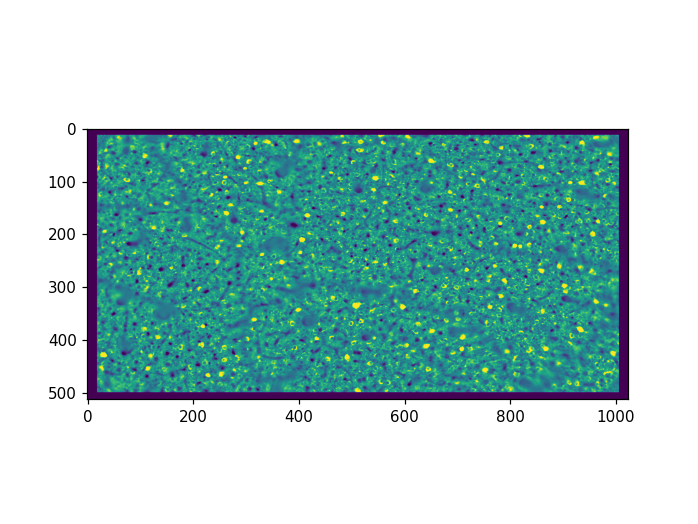

interactive(children=(IntSlider(value=0, description='i_frame', max=7), Output()), _dom_classes=('widget-inter…

In [9]:
%matplotlib notebook
display_toggle_image_stack(meanIms, clim=None)

## Make spatial_footprints
- Make a lazy list of all the spatial_footprints
- Convert spatial footprints to a sparse array (`ROIs_aligned`)

In [10]:
sf_all = import_and_convert_to_CellReg_spatialFootprints(paths_allStat, frame_height=frame_height, frame_width=frame_width, dtype=np.float32)

ROIs_aligned, FOVs_aligned, flows = register_ROIs(meanIms[0], meanIms, sf_all, return_sparse=True, normalize=True)

n_roi_per_sesh = [sfs.shape[0] for sfs in ROIs_aligned]
n_roi_all = np.sum(n_roi_per_sesh)

In [11]:
## remove NaNs from ROIs
for ii in range(len(ROIs_aligned)):
    print(ROIs_aligned[ii].data[np.isnan(ROIs_aligned[ii].data)])
    ROIs_aligned[ii].data[np.isnan(ROIs_aligned[ii].data)] = 0

[]
[]
[]
[]
[]
[]
[]
[]


Check to make sure the FOVs look aligned

<IPython.core.display.Javascript object>


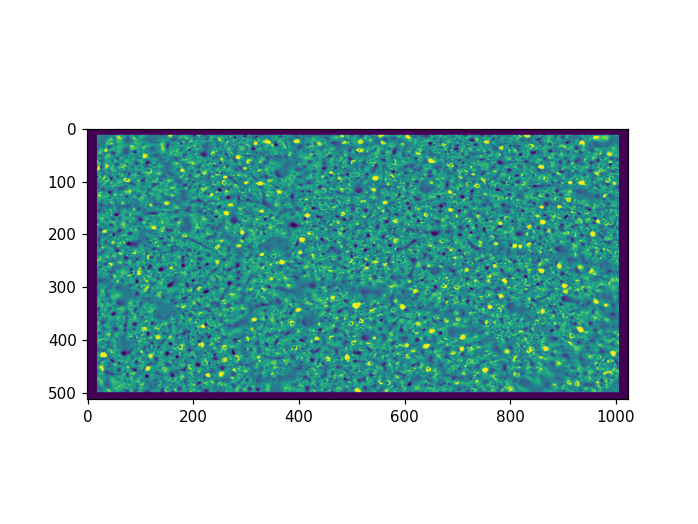

interactive(children=(IntSlider(value=0, description='i_frame', max=7), Output()), _dom_classes=('widget-inter…

In [12]:
display_toggle_image_stack(FOVs_aligned, clim=None)

<IPython.core.display.Javascript object>


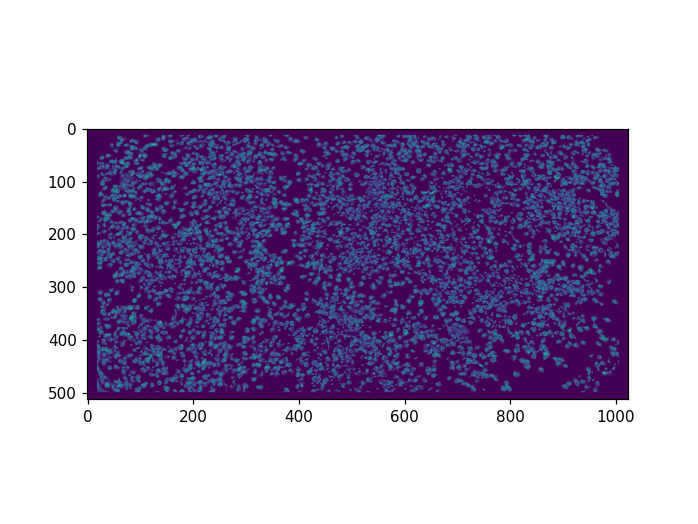

interactive(children=(IntSlider(value=0, description='i_frame', max=7), Output()), _dom_classes=('widget-inter…

In [13]:
display_toggle_image_stack([rois.multiply( rois.max(1).power(-1) ).sum(0).reshape(frame_height, frame_width) for rois in ROIs_aligned], clim=None)

<IPython.core.display.Javascript object>


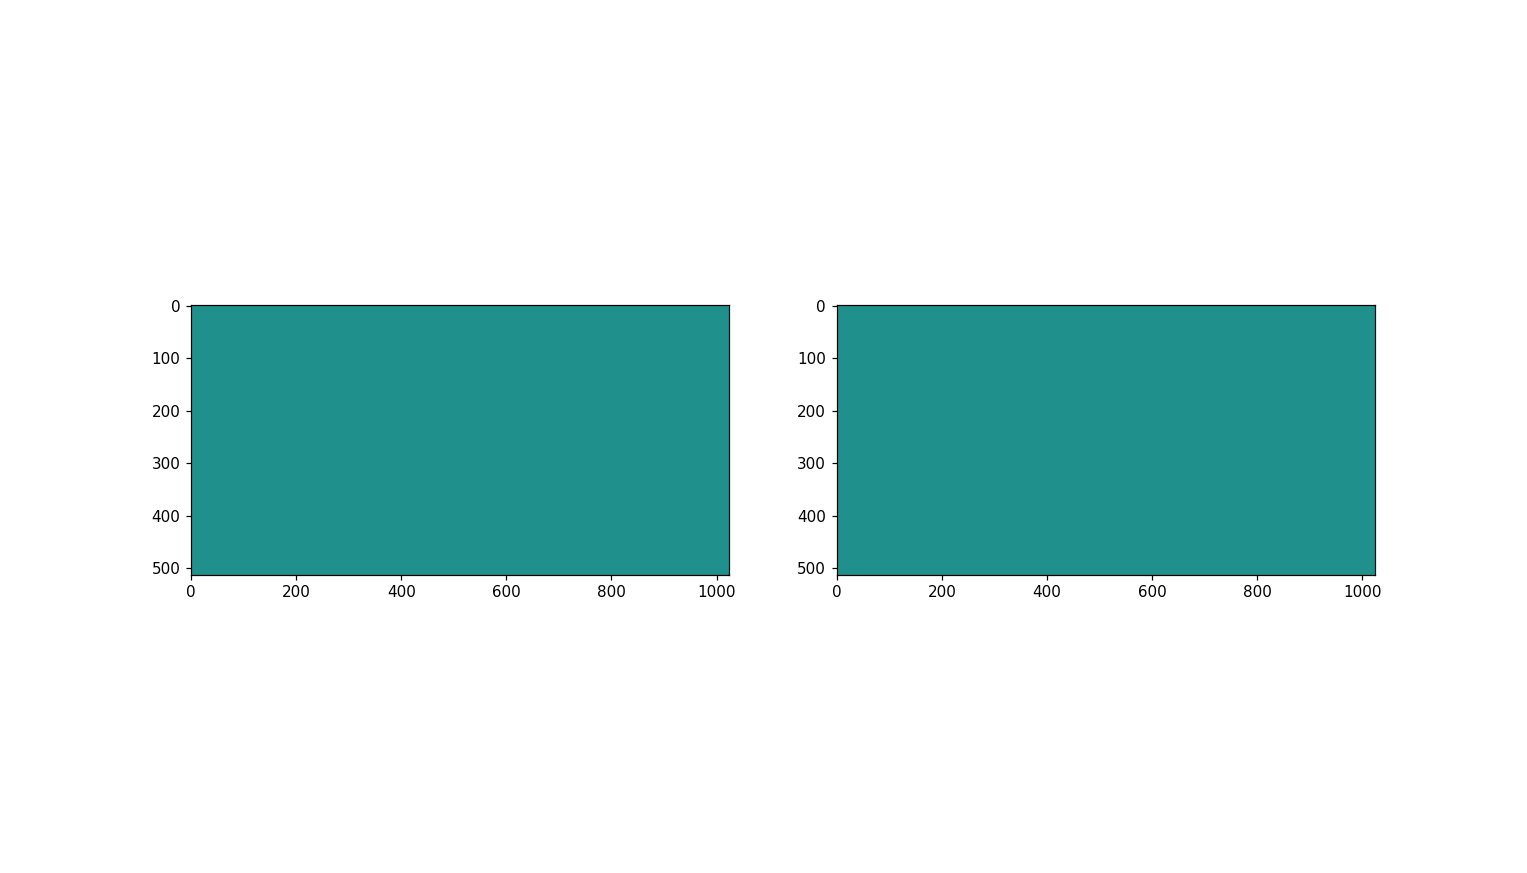

interactive(children=(IntSlider(value=0, description='i_frame', max=7), Output()), _dom_classes=('widget-inter…

In [14]:
display_toggle_2channel_image_stack(flows, clim=(-4,4))

## Blur ROIs (optional)

device: 'cuda'


<IPython.core.display.Javascript object>


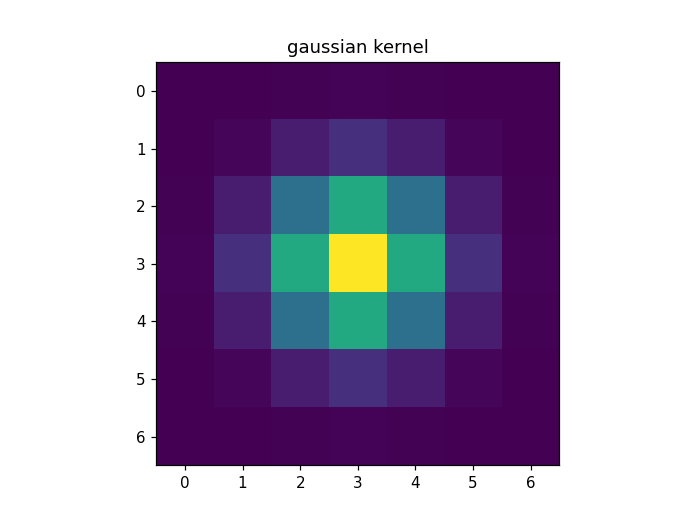

  0%|          | 0/8 [00:00<?, ?it/s]

In [15]:
## only needed if convolving ROIs and/or using neural net outputs for distance matrix
pref_blurROIs = True
DEVICE_blur = torch_helpers.set_device(use_GPU=use_GPU) # define torch device to use. either 'cpu', 'cuda', number, or something else. See torch_helpers.set_device()

if pref_blurROIs == True:
    kernel_size = 7 # Edge length of kernel image. Make odd number.
    kernel_sigma = 1 # sigma of 2D gaussian kernel
    kernel = featurization.gaussian_kernel_2D(center=(kernel_size//2, kernel_size//2), image_size=(kernel_size, kernel_size), sig=kernel_sigma)
    kernel = kernel / kernel.sum()

    ## show the kernel
    plt.figure()
    plt.imshow(kernel);
    plt.title('gaussian kernel')
    
    ROIs_aligned_blur = [batch_2D_sparse_convolution(
        images=rois, 
        kernel=kernel,
        image_shape=(frame_height, frame_width),
        num_batches=10,
        device=DEVICE_blur,
    ) for rois in tqdm(ROIs_aligned)]

<IPython.core.display.Javascript object>


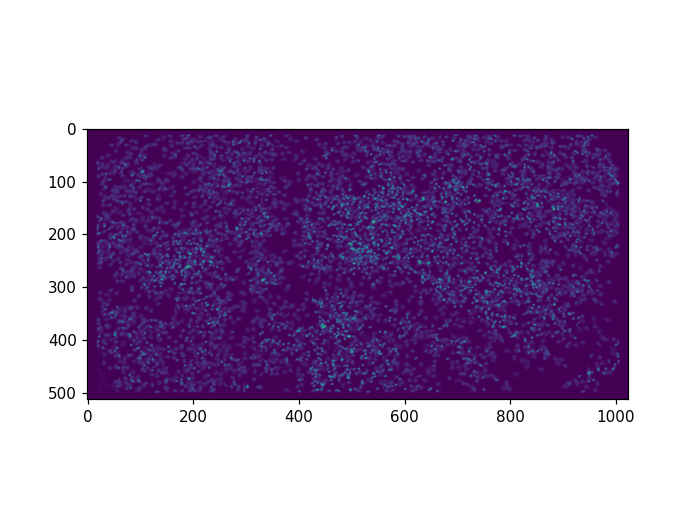

interactive(children=(IntSlider(value=0, description='i_frame', max=7), Output()), _dom_classes=('widget-inter…

In [16]:
display_toggle_image_stack([ROIs.sum(0).reshape(frame_height, frame_width) for ROIs in ROIs_aligned_blur])

## Neural network embedding distances

In [17]:
sf_all_cropped = util.import_multiple_stat_files(
    paths_statFiles=paths_allStat, 
#     dir_statFiles=None,
#     fileNames_statFiles=None,
    out_height_width=[36,36], 
    max_footprint_width=441, 
    plot_pref=False
)

In [18]:
device_model = torch_helpers.set_device(use_GPU=use_GPU)

model, model_module = import_pth_model(path_NN_pth, fileName_NN_py)

data = np.concatenate(sf_all_cropped, axis=0)

# Create Data Sets / Data Loaders
dataset, dataloader = model_module.get_dataset_dataloader(data, batch_size=64, device=device_model) ## TODO: Troubleshoot the runtime on this

# Get Model Latents
latents = simclr_helpers.dataloader_to_latents(dataloader, model.to(device_model), DEVICE=device_model)

device: 'cuda'


  0%|          | 0/611 [00:00<?, ?it/s]

## Scattering wavelet embedding distances

In [19]:
device_model = torch_helpers.set_device(use_GPU=use_GPU)

scattering = Scattering2D(J=2, L=8, shape=sf_all_cropped[0].shape[-2:])
if use_GPU:
    scattering = scattering.cuda()

latents_swt = torch.cat([get_latents_swt(sfs, scattering.cuda(), device_model).cpu() for sfs in sf_all_cropped], axis=0)

device: 'cuda'


## Make blocks

In [20]:
frame_height=FOVs_aligned[0].shape[0]
frame_width=FOVs_aligned[0].shape[1]
block_height=512
block_width=1024
overlapping_width_Multiplier=0.0
outer_block_height=512
outer_block_width=1024
clamp_outer_block_to_frame=True

inner_blocks, outer_blocks, centers = make_block_batches(
    frame_height=frame_height,
    frame_width=frame_width,
    block_height=block_height,
    block_width=block_width,
    overlapping_width_Multiplier=overlapping_width_Multiplier,
    outer_block_height=outer_block_height,
    outer_block_width=outer_block_width,
    clamp_outer_block_to_frame=clamp_outer_block_to_frame
)
n_blocks = len(inner_blocks)
# display(inner_blocks)
# display(outer_blocks)
print(f'number of blocks: {n_blocks}')

number of blocks: 1


<IPython.core.display.Javascript object>


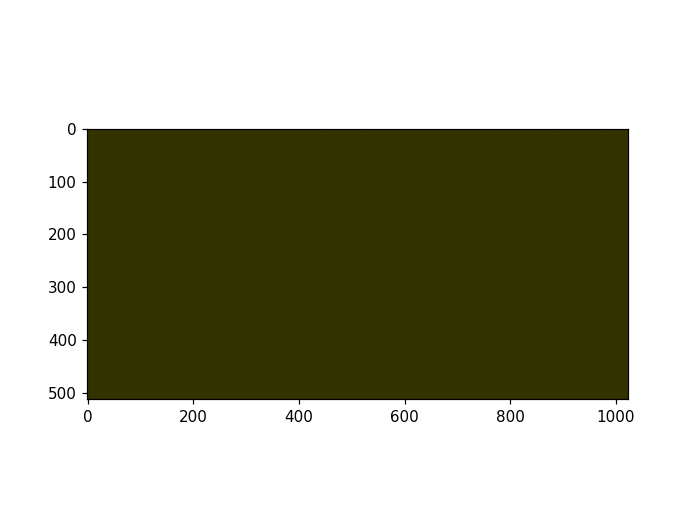

In [21]:
visualize_blocks(inner_blocks, outer_blocks, frame_height=512, frame_width=1024)

## t-SNE parameters

In [22]:
NN = sklearn.neighbors.NearestNeighbors(
#         n_neighbors=100,  ## currently using min(sf_block_flat.shape[0], max_n_neighbors)
#     radius=1.0, 
    algorithm='auto',
    leaf_size=30, 
    metric='manhattan',
    p=1,
#     metric_params=None, 
    n_jobs=-1
)

tsne = sklearn.manifold.TSNE(
    n_components=2,
#     perplexity=30.0,
    early_exaggeration=12.0,
    learning_rate='auto',
#     learning_rate=,
    n_iter=1000,
    n_iter_without_progress=300,
    min_grad_norm=1e-07,
    metric='precomputed',
    init='random',
    verbose=0,
    random_state=None,
    method='barnes_hut',
#     method='exact',
    angle=0.8,
    n_jobs=-1,
    square_distances=True,
)

In [23]:
max_n_neighbors = 100

# def embed_ROIs(
#     outer_blocks,
#     inner_blocks,
#     ROIs_toUse,
#     frame_height,
#     frame_width,
#     idx_roi_session,
#     tsne,
#     i_block,
#     mask_power,
#     max_n_neighbors,
#     pref_use_NN_distances,
#     latents,
#     latents_swt,
#     max_perplexity
# ):

i_block = 0

idx_roi_cat = np.concatenate([np.arange(sfs.shape[0]) for sfs in ROIs_aligned]) # indices of each ROI concatenated together
idx_roi_session = np.concatenate([np.ones(sfs.shape[0])*ii for ii,sfs in enumerate(ROIs_aligned)])

if pref_blurROIs:
# if False:
    ROIs_toUse = ROIs_aligned_blur
else:
    ROIs_toUse = ROIs_aligned
    
mask_power = 0.3
# max_n_neighbors = 100
# max_perplexity = 10

def get_ROI_idx_from_block_idx(block, spatial_footprints_flat, frame_height=frame_height, frame_width=frame_width):
    """
    This function:
     1. gets the indices of all the pixels in the block (return: idx_block)
     2. crops each spatial footprint image (size frame_height x frame_width) to just 
        the block pixels (return: sf_block_allSesh)
     3. finds the ROIs that are within the block and makes boolean and index output arrays listing them.
        Outputs:
         a. bool_ROI_inBlock_allSesh: a list where each entry is a session and each element is a boolean
            array listing whether that ROI is in the block
         b. idx_ROI_inBlock_allSesh: a list where each entry is a session and each element is the index
            of an ROI that is in the block
         c. boolCat_ROI_inBlock: an array listing which ROIs across all sessions that are in the block
         d. idxCat_ROI_inBlock: an array listing the indices of ROIs across all sessions that are in 
            the block
    """
    idx_block = np.reshape(
        np.ravel_multi_index(
            np.meshgrid(np.arange(block[0][0], block[0][1]), np.arange(block[1][0], block[1][1])),
            (frame_height, frame_width),
            order='C'),
        newshape=-1,
        order='F')

    sf_block_allSesh         = [sfs[:,idx_block] for sfs in spatial_footprints_flat]
    bool_ROI_inBlock_allSesh = [np.array(sfs.sum(1) > 0).squeeze() for sfs in sf_block_allSesh]
    idx_ROI_inBlock_allSesh  = [np.where(bool_ROI)[0] for bool_ROI in bool_ROI_inBlock_allSesh]

    boolCat_ROI_inBlock = np.concatenate(bool_ROI_inBlock_allSesh)
    idxCat_ROI_inBlock = np.where(boolCat_ROI_inBlock)[0]

    return idx_block, bool_ROI_inBlock_allSesh, idx_ROI_inBlock_allSesh, boolCat_ROI_inBlock, idxCat_ROI_inBlock, sf_block_allSesh

idx_outer_block, bool_ROI_inOuterBlock_allSesh, idx_ROI_inOuterBlock_allSesh, boolCat_ROI_inOuterBlock, idxCat_ROI_inOuterBlock, sf_OuterBlock_allSesh = \
    get_ROI_idx_from_block_idx(
        block=outer_blocks[i_block], 
        spatial_footprints_flat=ROIs_toUse, 
        frame_height=frame_height, 
        frame_width=frame_width
    )

idx_inner_block, bool_ROI_inInnerBlock_allSesh, idx_ROI_inInnerBlock_allSesh, boolCat_ROI_inInnerBlock, idxCat_ROI_inInnerBlock, sf_InnerBlock_allSesh = \
    get_ROI_idx_from_block_idx(
        block=inner_blocks[i_block], 
        spatial_footprints_flat=ROIs_toUse, 
        frame_height=frame_height, 
        frame_width=frame_width
    )


sf_block_inROIs_allSesh      = [sfs[idx_ROI_inOuterBlock_allSesh[ii],:] for ii,sfs in enumerate(sf_OuterBlock_allSesh)]
sf_block_flat        = scipy.sparse.vstack([sfs for sfs in sf_block_inROIs_allSesh])
sf_block_flat_scaled = sf_block_flat.power(mask_power)
sf_block_flat_scaled = sf_block_flat_scaled.multiply( 0.5 / sf_block_flat_scaled.sum(1)) # this scaling makes each ROI sum to 0.5, so the max distance between two ROIs is 1
sf_block_flat_scaled = scipy.sparse.csr_matrix(sf_block_flat_scaled)

n_neighbors = min(sf_block_flat_scaled.shape[0]-1, max_n_neighbors)
#     print(f'Using n_neighbors: {n_neighbors}')

distances_IOU = sklearn.neighbors.NearestNeighbors(
    algorithm='auto',
    leaf_size=30, 
    metric='manhattan',
    p=1,
#     metric_params=None, 
    n_jobs=-1
).fit(sf_block_flat_scaled).kneighbors_graph(
    sf_block_flat_scaled,
    n_neighbors=n_neighbors,
    mode='distance'
)

#     distances_IOU[distances_IOU>0.99] = distances_IOU[distances_IOU>0.99]*100


if pref_use_NN_distances:
#     if False:
    ltu = latents[idxCat_ROI_inOuterBlock]
    ltu = 1*(ltu / torch.sum(ltu, dim=1, keepdim=True))
    dist_latents_NN = torch.cdist(ltu, ltu, p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary').numpy()

    ltu = latents_swt[idxCat_ROI_inOuterBlock]
    ltu = 1*(ltu / torch.sum(ltu, dim=1, keepdim=True))
    dist_latents_swt = torch.cdist(ltu, ltu, p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary').numpy()

    dist_latents = dist_latents_NN * dist_latents_swt
#         dist_latents = dist_latents_NN 

#         ltu = latents_swt[idxCat_ROI_inOuterBlock]
#         ltu = 0.7071067811865476*(ltu / torch.sum(ltu, dim=1, keepdim=True))
#         cc_latents = np.corrcoef(ltu)
#         cc_latents[cc_latents<0] = 0
#         dist_latents = ((0+1) / (cc_latents**2)) -1
#         dist_latents = sim2dist(cc_latents,1,1)

    r = distances_IOU.tocoo().row
    c = distances_IOU.tocoo().col
    dist_latents_sparse = scipy.sparse.csr_matrix((dist_latents[r,c], (r,c)), shape=dist_latents.shape)

    distances_toUse = distances_IOU.power(1).multiply(dist_latents_sparse.power(1))
else:
    distances_toUse = distances_IOU.power(1)


distances_sessions = make_session_similarity_matrix(idx_roi_session[boolCat_ROI_inOuterBlock], d_diff=0, d_same=1)
distances_sessions = distances_sessions * np.logical_not(np.eye(distances_sessions.shape[0]))
r = distances_IOU.tocoo().row
c = distances_IOU.tocoo().col
distances_sessions_sparse = scipy.sparse.csr_matrix((distances_sessions[r,c], (r,c)), shape=distances_sessions.shape)


distances_toUse[distances_IOU>1] = 1
distances_toUse[distances_sessions_sparse.astype(np.bool8)] = 1
#     distances_toUse[distances_toUse>0.99] = 2



In [43]:
max_perplexity = 10

tsne.n_neighbors = n_neighbors
tsne.perplexity = min(max_perplexity, distances_toUse.shape[0]//4)
# print(tsne.perplexity)
#     if pref_use_GPU:
#         embeddings = tsne.fit_transform(
#             X=sf_block_flat_scaled,
#             knn_graph=distances_toUse
#         )
#     else:

if tsne.method == 'exact':
    distances_toUse = toDense_fill(distances_toUse, 1)

embeddings = tsne.fit_transform(
    X=distances_toUse,
#             X=distances_toUse.toarray(),
)

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-21.12/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


<IPython.core.display.Javascript object>


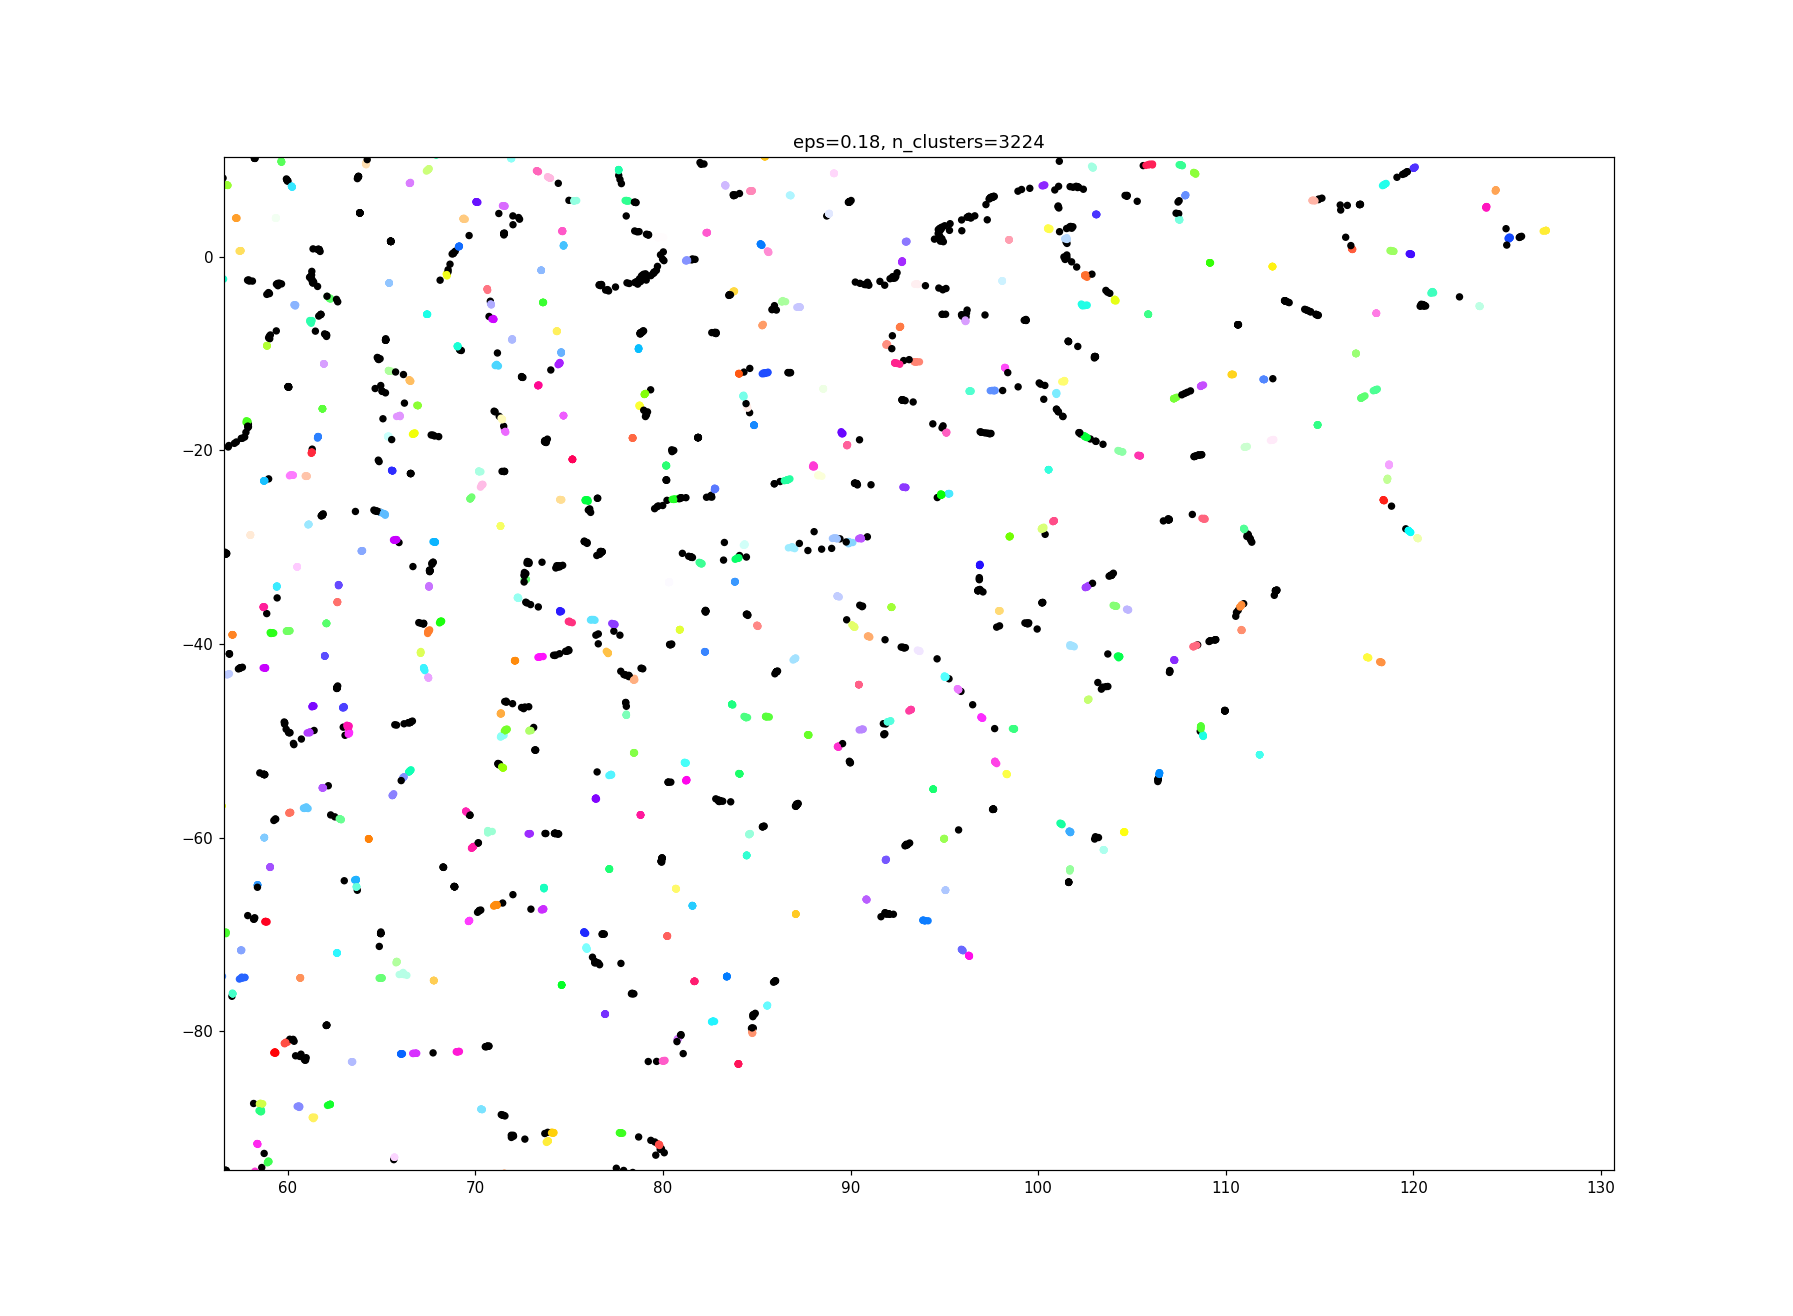

interactive(children=(IntSlider(value=200, description='eps', max=447, min=20), Output()), _dom_classes=('widg…

In [44]:
%matplotlib notebook

block_toUse = 40
min_samples = 6
max_samples = 8 # for use within this cell only (visualization and titrating eps value). Set to None to speed up visualization

embeddings = embeddings
    
display_clustering_widget(embeddings, min_samples, max_samples=max_samples, min_slider=0.01, max_slider=5, start_slider=1.0, single_color=False)

In [46]:
min_samples = 6
max_samples = 8

eps_toUse = 0.18


def get_val_counts(vals):
    vals_unique = np.unique(vals)
    vals_counts = np.zeros_like(vals, dtype=np.int64)
    for ii, val in enumerate(vals_unique):
        vals_counts[vals==val] = np.sum(vals==val)
    return vals_counts

# Compute DBSCAN
db = sklearn.cluster.DBSCAN(
    eps=eps_toUse,
    min_samples=min_samples, 
#         metric='manhattan',
    metric_params=None, 
    algorithm='auto',
    leaf_size=30, 
    p=2, 
    n_jobs=-1
).fit(embeddings)

labels = db.labels_
#     labels = db.labels_ - db.labels_.min()
if max_samples is not None:
    labels[get_val_counts(labels) > max_samples] = -1

Use this to adjust the number of sessions that are used

In [67]:
idx_toUse = np.arange(0,14500)

In [25]:
distances_ut = scipy.sparse.triu(distances_toUse[idx_toUse,:][:,idx_toUse], k=1)

In [26]:
idx_session_outerBlock = idx_roi_session[boolCat_ROI_inOuterBlock][idx_toUse]

In [27]:
partition = idx_session_outerBlock

<IPython.core.display.Javascript object>


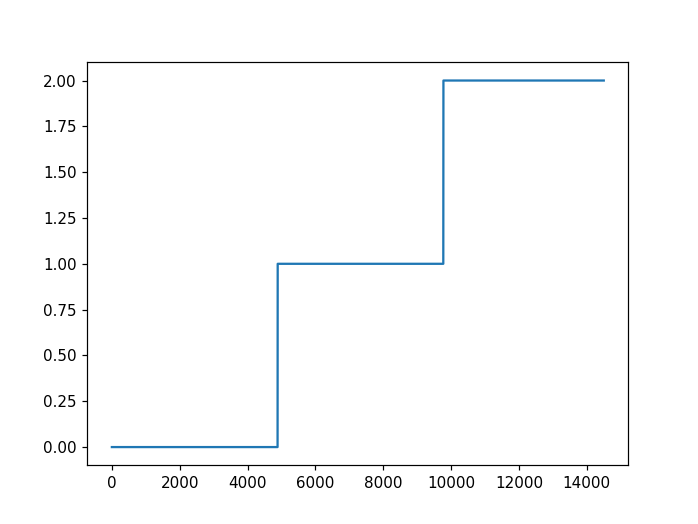

In [28]:
plt.figure()
plt.plot(partition)

In [29]:
dist_tmp = distances_ut.toarray()
dist_tmp[dist_tmp>1] = 1
dist_tmp[dist_tmp==0] = 1
dist_tmp, kl_bool = indexing.denseDistances_to_knnDistances(dist_tmp, k=8)

In [30]:
weights_tmp = dist_tmp.power(-1)
weights_tmp.data = np.log(weights_tmp.data)

In [31]:
weights = weights_tmp

In [32]:
sources,targets = weights.nonzero()
np.all(partition[sources] < partition[targets])    

True

In [33]:
tic = time.time()
out = similarity.maximum_directed_matching(weights, idx_session_outerBlock)
print(time.time() - tic)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-21.12/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/d7ab1c425f334c229a39cbeff2a394cf-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/d7ab1c425f334c229a39cbeff2a394cf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 14505 COLUMNS
At line 1319571 RHS
At line 1334072 BOUNDS
At line 1571856 ENDATA
Problem MODEL has 14500 rows, 237783 columns and 606212 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 115565 - 1.88 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 27 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 27 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 27 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bou

94.19726181030273


In [34]:
out

[(6498, 12087),
 (6549, 11402),
 (6554, 10972),
 (6546, 13457),
 (6445, 12734),
 (6479, 11518),
 (6564, 11303),
 (6649, 13085),
 (6640, 11125),
 (6657, 14208),
 (6708, 11685),
 (6686, 11217),
 (6682, 12668),
 (6568, 14475),
 (6623, 10929),
 (6636, 11324),
 (6255, 12431),
 (6257, 12812),
 (6231, 12521),
 (6128, 11332),
 (6172, 11076),
 (6166, 10693),
 (6346, 12690),
 (6376, 10943),
 (6260, 11995),
 (6275, 10990),
 (6271, 13211),
 (6329, 10680),
 (6309, 11634),
 (7125, 13088),
 (7129, 12669),
 (7128, 13935),
 (7159, 11296),
 (7152, 13191),
 (7043, 13192),
 (7028, 13214),
 (7023, 11602),
 (7086, 13014),
 (7088, 11894),
 (7286, 11670),
 (7267, 13668),
 (7294, 14091),
 (7210, 10566),
 (7191, 11879),
 (7234, 11628),
 (7247, 14370),
 (7215, 11521),
 (6818, 11875),
 (6829, 11692),
 (6851, 11207),
 (6868, 14429),
 (6842, 10953),
 (6741, 10192),
 (6743, 13293),
 (6730, 11141),
 (6777, 11138),
 (6757, 11066),
 (6767, 11975),
 (6962, 11505),
 (7002, 11855),
 (6984, 11145),
 (7001, 12451),
 (6870, 

In [36]:
# cids = -1 * np.ones(weights.shape[0])
cids = -1 * np.ones(n_roi_all, dtype=np.int32)
for i_c, cid in enumerate(out):
#     print(list(cid))
    if np.allclose(cids[list(cid)], -1*np.ones(len(list(cid)))) == 0:
        print('hi')
    cids[list(cid)] = i_c

In [70]:
n_planes = n_sessions = 3
labels = cids
# labels = labels

ucid_toUse = labels[idx_toUse]
idx_roi_session_toUse = idx_roi_session[boolCat_ROI_inOuterBlock][idx_toUse]

cmaps = sparse.COO(rand_cmap(len(np.unique(ucid_toUse)), verbose=False)(np.int32(ucid_toUse))[:,:3])
plane_oneHot = classification.idx_to_oneHot(idx_roi_session_toUse.astype(np.int32))

ROIs_csr = scipy.sparse.csr_matrix(scipy.sparse.vstack(ROIs_aligned))[idx_toUse]
ROIs_csr_scaled = ROIs_csr.multiply(ROIs_csr.max(1).power(-1))
ROIs_sCOO = sparse.COO(ROIs_csr_scaled)

def tile_sparse(arr, n_tiles):
    """
    tiles along new (last) dimension
    """
    out = sparse.stack([arr for _ in range(n_tiles)], axis=-1)
    return out

ROIs_tiled = tile_sparse(tile_sparse(ROIs_sCOO, n_planes), 3)

ROIs_colored = ROIs_tiled * cmaps[:,None,None,:] * plane_oneHot[:,None,:,None]

FOV_ROIs_colored = ROIs_colored.sum(0).reshape((frame_height, frame_width, n_planes, 3)).transpose((2,0,1,3))

In [71]:
# FOV_toShow = im_FOV.transpose((0,2,3,1))
FOV_toShow = FOV_ROIs_colored.todense()

FOV_all_noClip = copy.copy(FOV_toShow)
FOV_all_noClip[FOV_all_noClip>1] = 1

In [73]:
plotting_helpers.play_video_cv2(FOV_all_noClip*255, frameRate=3, 
                                save_path='/home/rich/Desktop/test_caleb_nHungarian_mouse_2_6.avi'
                           )

saving to file /home/rich/Desktop/test_caleb_nHungarian_mouse_2_6.avi
Video saved


<IPython.core.display.Javascript object>


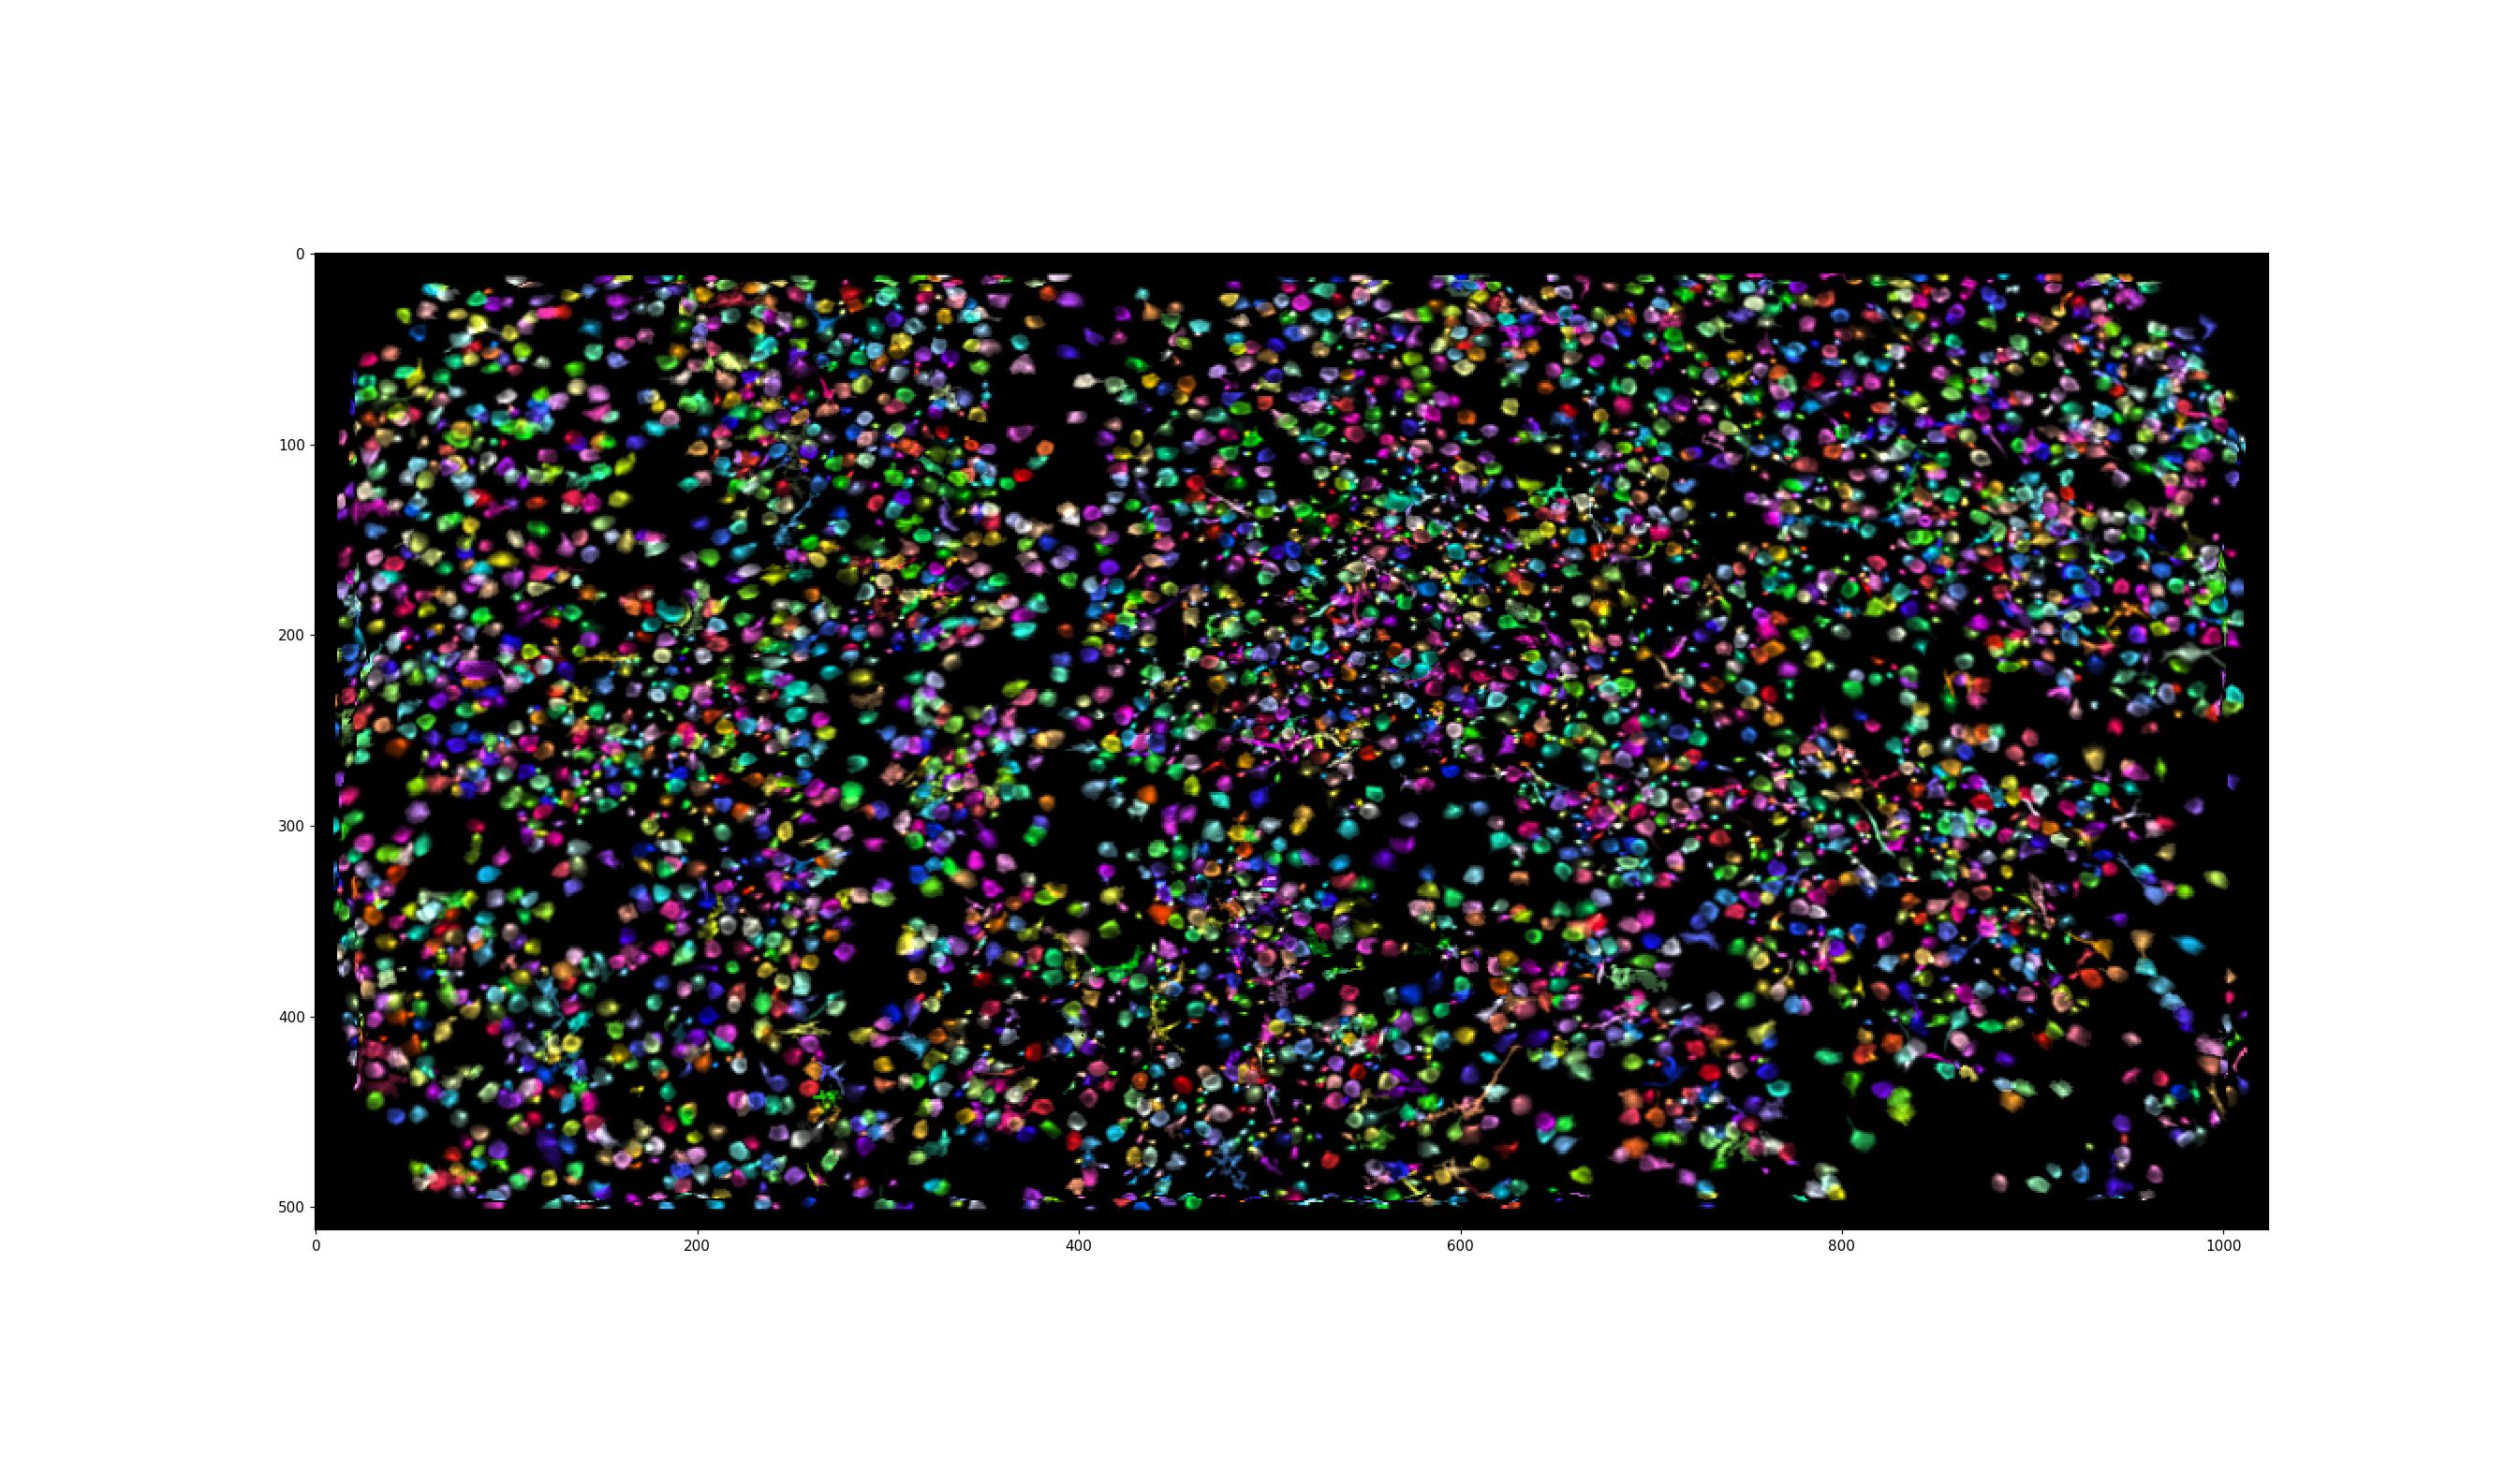

interactive(children=(IntSlider(value=0, description='i_frame', max=2), Output()), _dom_classes=('widget-inter…

In [74]:
%matplotlib notebook
from ipywidgets import *


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
imshow_FOV = ax.imshow(FOV_all_noClip[0], interpolation='none')

def update(i_frame = 0):
    fig.canvas.draw_idle()
    imshow_FOV.set_data(FOV_all_noClip[i_frame])


interact(update, i_frame=widgets.IntSlider(min=0, max=FOV_all_noClip.shape[0]-1, step=1, value=0));

outputs:
`UCIDs`
`UCIDs_bySession`

In [376]:
dir_save = Path(r'D:\RH_local\data\scanimage data\round 5 experiments\mouse 2_6\20210410_test\analysis_lastNight').resolve()

In [377]:
pickle_helpers.simple_save(
    {
    "UCIDs": UCIDs,
    "UCIDs_bySession": UCIDs_bySession,
    },
    filename=dir_save / 'UCIDs_20220208.pkl'
#     filename='/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/UCIDs.pkl'
)